## Introduction

## Data Preperation

### Load Data from Github

The code below uses the requests library to fetch contnets of the projects repository and fetches each text document in the sub directories 'pos' and 'neg'. The documents fetched are used to create a Dataframe with all reviews and the type of the review (as either 'neg' or 'pos'). The code then goes on to print the head of the dataframe.

In [7]:
import requests
import pandas as pd

base_url = "https://api.github.com/repos/ktxdev/AIM-5001/contents/"

def create_reviews_dataframe(base_url, path, dfs = []):
    '''
    Uses the given base url to fetch contents from github using the GitHub API and returns a dataframe containing labeled data
    '''
    url = f"{base_url}{path}"
    response = requests.get(url)

    # Process response if request was successful
    if response.status_code == 200:
        # Store json content from the request
        contents = response.json()

        # Iterate over each item in the response's json content
        for item in contents:
            # Validate the type of item 
            if item['type'] == 'file':
                # Get the file 
                review = requests.get(item['download_url'])
                # Get text contained in the file
                text = review.text
                # Get type of review from path
                type = 'pos' if path.endswith('pos') else 'neg'
                # Create a dataframe for the current file
                df2 = pd.DataFrame({'text': [text], 'type': [type]})
                # Append the dataframe to the main dataframe
                dfs.append(df2)
            elif item['type'] == 'dir':
                # Recursive call 
                create_reviews_dataframe(base_url, item['path'], dfs)
    else:
        print(f"Failed to fetch directory contents with status code: {response.status_code}")
    
    # Create data frame with the results
    return pd.concat(dfs, ignore_index=True)

reviews_df = create_reviews_dataframe(base_url, "M12/Assn/1.%20Data")
reviews_df.head()

,text,type
0,"plot : two teen couples go to a church party ,...",neg
1,the happy bastard's quick movie review \ndamn ...,neg
2,it is movies like these that make a jaded movi...,neg
3,""" quest for camelot "" is warner bros . ' firs...",neg
4,synopsis : a mentally unstable man undergoing ...,neg


### Preprocessing the data

In this step I will preprocess the data by converting it to lower case, removing all panctuations and stop words, and also lemmatizes the text. The code then goes on to print the first 5 items from the dataframe

In [10]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Get all english stop wods
english_stopwords = stopwords.words('english')

# Converting text to lowercase
reviews_df['text'] = reviews_df['text'].str.lower()
# Remove panctuations
reviews_df['text'] = reviews_df['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in string.punctuation))
# Remove stopwords
reviews_df['text'] = reviews_df['text'].apply(lambda x: ' '.join(x for x in x.split() if x not in english_stopwords))
# Lemmatize the words
lemmatizer = WordNetLemmatizer()
reviews_df['text'] = reviews_df['text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(x) for x in x.split()))
reviews_df.head()


,text,type
0,plot two teen couple go church party drink dri...,neg
1,happy bastard's quick movie review damn y2k bu...,neg
2,movie like make jaded movie viewer thankful in...,neg
3,quest camelot warner bros first feature-length...,neg
4,synopsis mentally unstable man undergoing psyc...,neg


### Creating the Term-Document Matrix

This code first creates a default vocabulary which will store all the words in the text. It then goes on to create a word count by iterating over each review from the reviews_df dataframe. The document then creates a list of lists containing zeros that is later used to store the counts for each reviews vocabulary words in the review_df. A term document matrix dataframe is then created and then mergedwith the review dataframe. The code then print the head of the newly created dataframe.  

In [24]:
from collections import Counter, defaultdict

vocabulary = defaultdict()
vocabulary.default_factory = lambda: len(vocabulary)

word_counts = []
# Iterate over each review
for review in reviews_df['text']:
    words = review.split()
    # Create a frequency count for the word
    counts = Counter(words)
    # Append word's count to the word counts list
    word_counts.append({vocabulary[word]: count for word, count in counts.items()})

# Create a list with zeros for the term mdocument matrix
term_document_matrix = [[0] * len(vocabulary) for _ in range(len(reviews_df['text']))]

# Iterate over each word count
for idx, word_count in enumerate(word_counts):
    # Iterate over each word counts values
    for word_idx, freq in word_count.items():
        term_document_matrix[idx][word_idx] = freq

term_document_matrix_df = pd.DataFrame(term_document_matrix, columns=vocabulary)

term_document_matrix_df = pd.merge(reviews_df, term_document_matrix_df, left_index=True, right_index=True)
term_document_matrix_df.head()


,text_x,type_x,plot,two,teen,couple,go,church,party,drink,...,cage-world,snoot,obstruction,obscuring,tangerine,timbre,glass',powaqqatsi,keyboardist,capitalized
0,plot two teen couple go church party drink dri...,neg,1,2,4,1,2,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,happy bastard's quick movie review damn y2k bu...,neg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,movie like make jaded movie viewer thankful in...,neg,2,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,quest camelot warner bros first feature-length...,neg,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,synopsis mentally unstable man undergoing psyc...,neg,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate Matrix Sparsity

In [15]:
total_items = term_document_matrix_df.size


92774000

## Frequency Distribution Plots

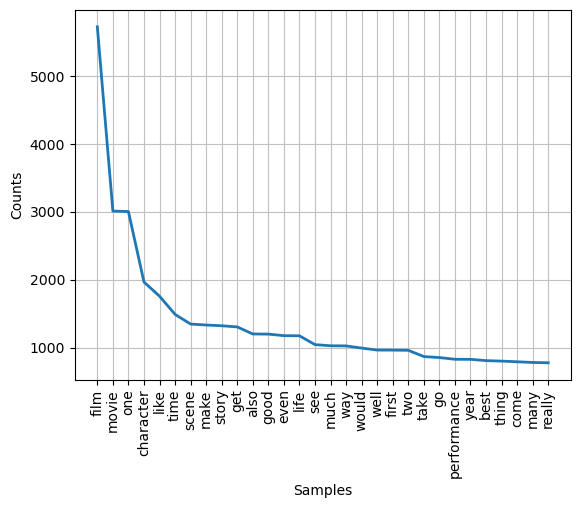

<Axes: xlabel='Samples', ylabel='Counts'>

In [26]:
from nltk import FreqDist

positive_reviews = term_document_matrix_df[term_document_matrix_df['type_x'] == "pos"]

pos_words = [word for review in positive_reviews['text_x'].str.split() for word in review]
pos_word_freq = FreqDist(pos_words)
pos_word_freq.plot(30, cumulative=False)

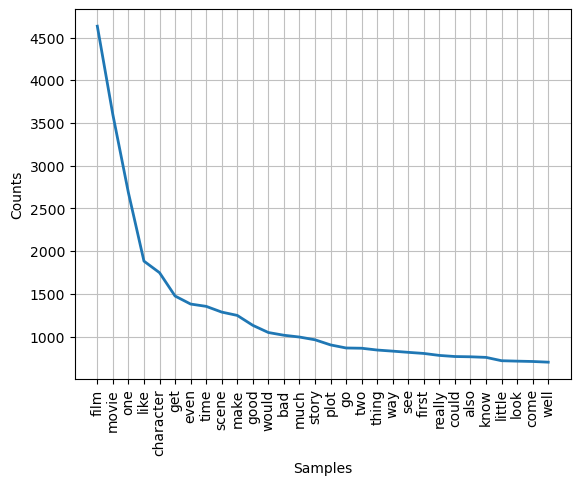

<Axes: xlabel='Samples', ylabel='Counts'>

In [27]:
negative_reviews = term_document_matrix_df[term_document_matrix_df['type_x'] == "neg"]

neg_words = [word for review in negative_reviews['text_x'].str.split() for word in review]
neg_word_freq = FreqDist(neg_words)
neg_word_freq.plot(30, cumulative=False)

From the above 2 frequency plots we can see that in both dataframes the most used words are film, movie, one and like.

## Sentiment Analysis Model Preparation

In [32]:
from random import shuffle
train_sample_size = int(len(positive_reviews) * 0.75)

positive_reviews.sample(frac=1).reset_index(drop=True)
negative_reviews.sample(frac=1).reset_index(drop=True)


,text_x,type_x,plot,two,teen,couple,go,church,party,drink,...,cage-world,snoot,obstruction,obscuring,tangerine,timbre,glass',powaqqatsi,keyboardist,capitalized
0,note may consider portion following text spoil...,neg,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,army comedy genre never turned truly good movi...,neg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,well here's distasteful thoroughly amateurish ...,neg,0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,experience like baby genius certain effect ave...,neg,3,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,great anticipation sat view braveheart last we...,neg,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,new address old attitude forget recommend film...,neg,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,saw film christmas day expecting upbeat comedy...,neg,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,plot little boy born east germany named hansel...,neg,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,first scene operation condor jackie chan prepa...,neg,2,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
